# Metro -  Dataset

URL: http://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

## Content

1) [Data preprocessing](#dataproc)

2) [Model training and evaluation](#train) 
    
2.a) [Linear regression](#linear)

2.b) [Lasso Regression](#lasso)

2.c) [Random Forest](#rf)

2.d) [kNN](#knn)

---



In [1]:
# Basic imports
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# models for linear regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# models for Lasso regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Imports for RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# statistic tools
from sklearn import metrics
from statistics import stdev

# data processing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
input_file = 'Metro_Interstate_Traffic_Volume.csv'
df_raw = pd.read_csv(input_file,  sep = ',', header = 0)
df_raw

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [3]:
col_dict = {'holiday':  'Name of the holiday (object)', 
            'temp':  'temperature[Kelvin]',
            'rain_1h':  'Amount of rain in 1 hour[mm]',
            'snow_1h':  'Amount of snow in 1 hour[mm]',
            'clouds_all':  'percentage of clounds ',
            'weather_main':  'discribe the current wheather situation',
            'weather_description':  'more precise description of the weather situation',
            'date_time': 'time: YYYY/MM/DD/hh/mm/ss',
            'traffic_volume': 'Amount of numbers of cars in 1h (target)',
            'year': 'year',
            'month':  'month',
            'day':  'day',
            'hour':  'hour',
           }

In [4]:
import math
from sklearn.metrics import r2_score
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m, X_train, X_valid, y_train, y_valid, score=''):
    res = {
        'RMS(train)': rmse(m.predict(X_train), y_train),
        'RMS(test)': rmse(m.predict(X_valid), y_valid)}
    if score=='neg_mean_squared_error':
        r2tr = r2_score(y_train, m.predict(X_train))
        r2te = r2_score(y_valid, m.predict(X_valid))
    else:
        r2tr = m.score(X_train, y_train)
        r2te = m.score(X_valid, y_valid)
    res['R2(train)'] = r2tr
    res['R2(test)'] = r2te
    #if hasattr(m, 'oob_score_'): res['oob_score_'] = m.oob_score_
    display(res)
    return res

# Feature importance
from prettytable import PrettyTable as PT # pip install PTable
def print_RF_featureImportance(rf, X):
    table = PT()
    table.field_names = ['Feature', 'Score', 'Comment']
    sum = 0
    for name, score in zip(X.columns.values, rf.feature_importances_):
        print(f"{name}: {score:.5f}\t\t... {col_dict[name]}")
        table.add_row([name, round(score, ndigits=4), col_dict[name]])
        sum += score
    print(table)
    print(f"sum = {sum}")

def print_GridSearchResult(grid):
    print(grid.best_params_)
    print(grid.best_estimator_)

# Preprocessing

## convert the date_time in 4 different coloums 

In [5]:
df_raw["date_time"] = pd.to_datetime(df_raw.date_time)
df_raw["hour"] = df_raw.date_time.dt.hour
df_raw["day"] = df_raw.date_time.dt.day
df_raw["month"] = df_raw.date_time.dt.month
df_raw["year"] = df_raw.date_time.dt.year

df_raw = df_raw.drop("date_time", axis=1)

df_raw

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day,month,year
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,9,2,10,2012
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,10,2,10,2012
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,11,2,10,2012
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,12,2,10,2012
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,13,2,10,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543,19,30,9,2018
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781,20,30,9,2018
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159,21,30,9,2018
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,1450,22,30,9,2018


In [6]:
weather_cond = []
weather_des = []

weather_cond = pd.unique(df_raw.weather_main)
weather_des = pd.unique(df_raw.weather_description)
df_raw.holiday[df_raw.holiday == "None"] = 0
df_raw.holiday[df_raw.holiday != 0] = 1

df_raw.temp[df_raw.temp < 100] = np.mean(df_raw.temp)
df_raw.rain_1h[df_raw.rain_1h > 100] = 0

for i in range(len(weather_cond)):
    df_raw.weather_main[df_raw.weather_main == weather_cond[i]] = i+1
    
for i in range(len(weather_des)):
    df_raw.weather_description[df_raw.weather_description == weather_des[i]] = i+1

df_raw[["temp", "rain_1h","snow_1h","traffic_volume","clouds_all","weather_main","weather_description"]] = df_raw[["temp", "rain_1h","snow_1h","traffic_volume","clouds_all","weather_main","weather_description"]].astype(float)

/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/alexander/.local/lib/python3

## sclaes  the dataset in a range from (0,1)

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()

df_raw[["temp", "rain_1h","snow_1h","traffic_volume","clouds_all","weather_main","weather_description"]] = min_max_scaler.fit_transform(df_raw[["temp", "rain_1h","snow_1h","traffic_volume","clouds_all","weather_main","weather_description"]])


df_raw

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day,month,year
0,0,0.673215,0.0,0.0,0.40,0.0,0.000000,0.761676,9,2,10,2012
1,0,0.689412,0.0,0.0,0.75,0.0,0.027027,0.620330,10,2,10,2012
2,0,0.692711,0.0,0.0,0.90,0.0,0.054054,0.654808,11,2,10,2012
3,0,0.700960,0.0,0.0,0.90,0.0,0.054054,0.690385,12,2,10,2012
4,0,0.716107,0.0,0.0,0.75,0.0,0.027027,0.675549,13,2,10,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
48199,0,0.600780,0.0,0.0,0.75,0.0,0.027027,0.486676,19,30,9,2018
48200,0,0.590432,0.0,0.0,0.90,0.0,0.054054,0.382005,20,30,9,2018
48201,0,0.589982,0.0,0.0,0.90,0.7,0.378378,0.296566,21,30,9,2018
48202,0,0.580384,0.0,0.0,0.90,0.0,0.054054,0.199176,22,30,9,2018


## prepare the rushhour dataset 

In [8]:
df_raw_rush = df_raw[(df_raw['hour'] >= 8) & (df_raw['hour'] < 11) | (df_raw['hour'] < 18) & (df_raw['hour'] > 15)]
df_raw_rush

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day,month,year
0,0,0.673215,0.0,0.0,0.40,0.0,0.000000,0.761676,9,2,10,2012
1,0,0.689412,0.0,0.0,0.75,0.0,0.027027,0.620330,10,2,10,2012
7,0,0.756899,0.0,0.0,0.01,0.1,0.081081,0.826236,16,2,10,2012
8,0,0.761098,0.0,0.0,0.20,0.0,0.108108,0.795467,17,2,10,2012
22,0,0.520846,0.0,0.0,0.01,0.1,0.081081,0.894368,8,3,10,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
48186,0,0.553239,0.0,0.0,0.90,0.0,0.054054,0.275000,8,30,9,2018
48187,0,0.558338,0.0,0.0,0.90,0.0,0.054054,0.395879,9,30,9,2018
48188,0,0.569736,0.0,0.0,0.75,0.0,0.027027,0.508379,10,30,9,2018
48196,0,0.614727,0.0,0.0,0.75,0.2,0.135135,0.588324,16,30,9,2018


# Preprocessing LinReg

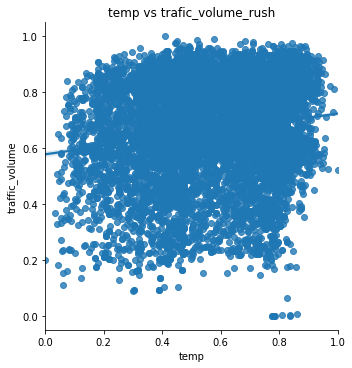

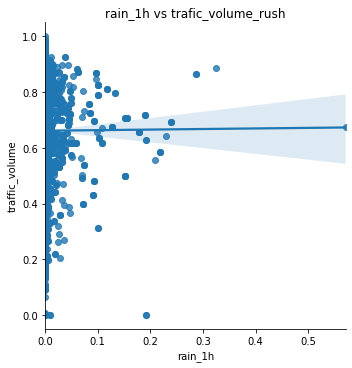

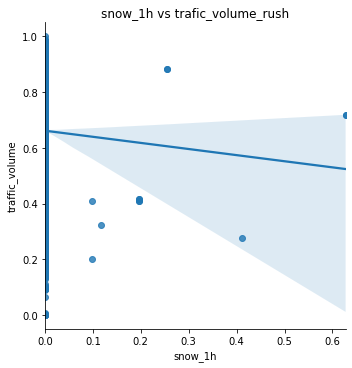

In [9]:
df_plot = df_raw_rush
sns_plot = sns.lmplot("temp","traffic_volume",df_plot)
ax = plt.gca()
ax.set_title("temp vs trafic_volume_rush")
sns_plot.savefig("plots/Metro/temp vs trafic_volume_rush")

sns_plot = sns.lmplot("rain_1h","traffic_volume",df_plot)
ax = plt.gca()
ax.set_title("rain_1h vs trafic_volume_rush")
sns_plot.savefig("plots/Metro/rain_1h vs trafic_volume_rush")

sns_plot = sns.lmplot("snow_1h","traffic_volume",df_plot)
ax = plt.gca()
ax.set_title("snow_1h vs trafic_volume_rush")
sns_plot.savefig("plots/Metro/snow_1h vs trafic_volume_rush")


# Preprocessing for kNN

In [10]:
from sklearn.impute import SimpleImputer

df_knn = df_raw

from sklearn.impute import SimpleImputer
df_raw

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day,month,year
0,0,0.673215,0.0,0.0,0.40,0.0,0.000000,0.761676,9,2,10,2012
1,0,0.689412,0.0,0.0,0.75,0.0,0.027027,0.620330,10,2,10,2012
2,0,0.692711,0.0,0.0,0.90,0.0,0.054054,0.654808,11,2,10,2012
3,0,0.700960,0.0,0.0,0.90,0.0,0.054054,0.690385,12,2,10,2012
4,0,0.716107,0.0,0.0,0.75,0.0,0.027027,0.675549,13,2,10,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
48199,0,0.600780,0.0,0.0,0.75,0.0,0.027027,0.486676,19,30,9,2018
48200,0,0.590432,0.0,0.0,0.90,0.0,0.054054,0.382005,20,30,9,2018
48201,0,0.589982,0.0,0.0,0.90,0.7,0.378378,0.296566,21,30,9,2018
48202,0,0.580384,0.0,0.0,0.90,0.0,0.054054,0.199176,22,30,9,2018


---
# 2) Model training and evaluation
---

## a) Linear Regression

In [11]:
df_lin = df_raw_rush

In [12]:
Y = df_lin[['traffic_volume']]
X = df_lin[['holiday','temp','rain_1h','snow_1h','hour','day','month','year',"clouds_all","weather_main","weather_description"]]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)

In [13]:
linreg = LinearRegression(normalize = True)
linreg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [14]:
Y_lin_pred = linreg.predict(X_test)
print_score(linreg, X_train, X_test, Y_train, Y_test)

{'RMS(train)': 0.16034357195512425,
 'RMS(test)': 0.1600955848899509,
 'R2(train)': 0.1712496181843222,
 'R2(test)': 0.15433417518307213}

{'RMS(train)': 0.16034357195512425,
 'RMS(test)': 0.1600955848899509,
 'R2(train)': 0.1712496181843222,
 'R2(test)': 0.15433417518307213}

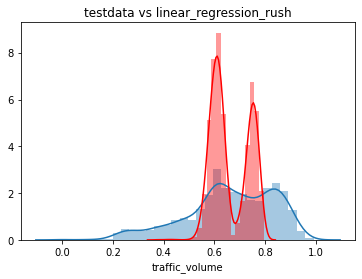

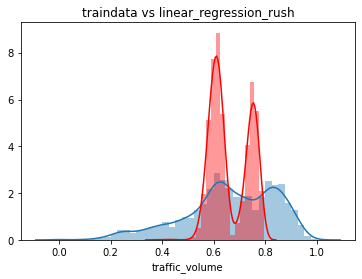

In [15]:
sns_plot = sns.distplot(Y_test)
sns.distplot(Y_lin_pred, color="red")

ax = plt.gca()
ax.set_title("testdata vs linear_regression_rush")
fig = sns_plot.get_figure()
plt.xlabel("traffic_volume")
fig.savefig("plots/Metro/testdata vs linear_regression_rush")

plt.figure()
sns_plot = sns.distplot(Y_train)
sns.distplot(Y_lin_pred, color="red")
ax = plt.gca()
ax.set_title("traindata vs linear_regression_rush")
fig = sns_plot.get_figure()
plt.xlabel("traffic_volume")
fig.savefig("plots/Metro/traindata vs linear_regression_rush")

# b) Lasso Regression

In [16]:
lasso = Lasso(normalize = True)
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,2,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor = GridSearchCV(lasso,parameters,scoring = 'neg_mean_squared_error',cv = 5)

In [17]:
lasso_regressor.fit(X_train,Y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 1e-08}
-0.025786834271342252


In [18]:
Y_lasso_pred = lasso_regressor.predict(X_test)

In [19]:
 print('R2(Test):', metrics.mean_squared_error(Y_test, Y_lasso_pred))  
print('RMS(Test):', np.sqrt(metrics.mean_squared_error(Y_test, Y_lasso_pred)))  

R2(Test): 0.025630530097034462
RMS(Test): 0.16009537812514907


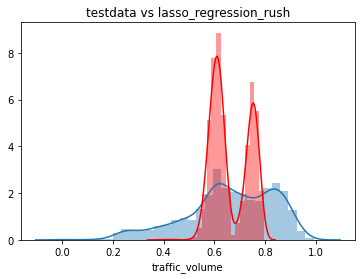

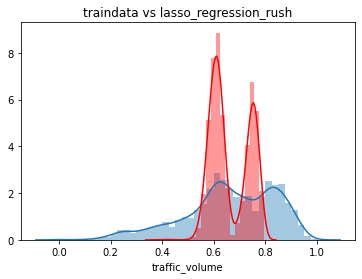

In [20]:
sns.distplot(Y_test)
sns.distplot(Y_lasso_pred, color="red")
ax = plt.gca()
ax.set_title("testdata vs lasso_regression_rush")
fig = sns_plot.get_figure()
plt.xlabel("traffic_volume")
fig.savefig("plots/Metro/testdata vs lasso_regression_rush")

plt.figure()
sns.distplot(Y_train)
sns.distplot(Y_lasso_pred, color="red")
ax = plt.gca()
ax.set_title("traindata vs lasso_regression_rush")
fig = sns_plot.get_figure()
plt.xlabel("traffic_volume")
fig.savefig("plots/Metro/traindata vs lasso_regression_rush")

# c) kNN

In [21]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

In [22]:
rmse_val_knn = [] # to store rmse values for different k
for k in range(25):
    k = k + 1
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    error = sqrt(mean_squared_error(Y_test, pred))
    rmse_val_knn.append(error)
    print("RMSE for k={}: {}".format(k, error))
    print("R^2 for k={}: {}\n".format(k, model.score(X_test, Y_test)))

RMSE for k=1: 0.13525172677147745
R^2 for k=1: 0.39643269400578657

RMSE for k=2: 0.12541845264423648
R^2 for k=2: 0.48100527159625933

RMSE for k=3: 0.12443281439874476
R^2 for k=3: 0.48913056725980353

RMSE for k=4: 0.12531938992332217
R^2 for k=4: 0.4818248116936775

RMSE for k=5: 0.1267914340129675
R^2 for k=5: 0.46957999242089354

RMSE for k=6: 0.12872449694544638
R^2 for k=6: 0.4532831282527429

RMSE for k=7: 0.13079358818424258
R^2 for k=7: 0.43556624433086916

RMSE for k=8: 0.13347956458316465
R^2 for k=8: 0.41214579040907284

RMSE for k=9: 0.13539671586211824
R^2 for k=9: 0.3951379588862821

RMSE for k=10: 0.13724355787216164
R^2 for k=10: 0.37852450907119384

RMSE for k=11: 0.138766157265124
R^2 for k=11: 0.3646585443440537

RMSE for k=12: 0.14017011021592513
R^2 for k=12: 0.3517375002337603

RMSE for k=13: 0.1413984357881391
R^2 for k=13: 0.3403261324820456

RMSE for k=14: 0.1426857736139226
R^2 for k=14: 0.3282596775630715

RMSE for k=15: 0.1435988392306081
R^2 for k=15: 0.

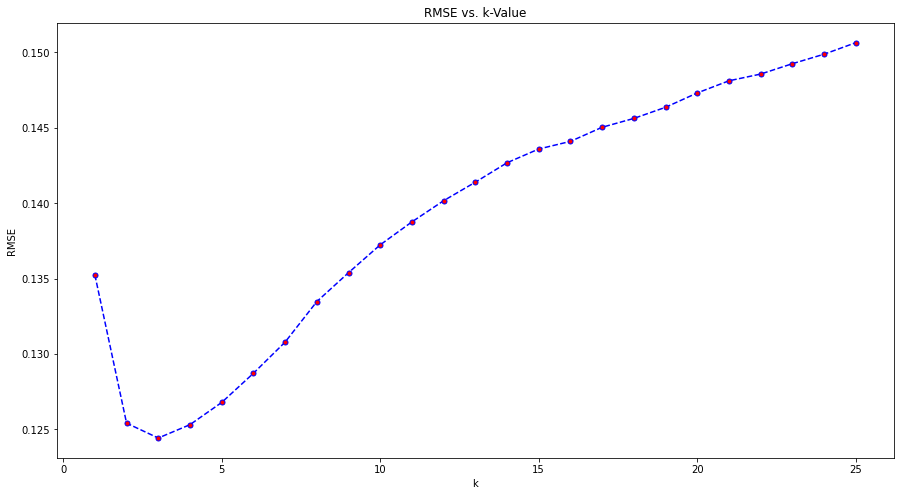

In [23]:
plt.figure(figsize=(15,8))
plt.plot(range(1,26), rmse_val_knn, color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=5)
plt.title('RMSE vs. k-Value')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.savefig("plots/Metro/RMSE vs k-Value_rush")

## Optimizing kNN-search for optimal k-Value via Gridsearch

In [24]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(1, 25)}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=10)
model.fit(X_train, Y_train)
print("Best k-Value is: ", model.best_params_['n_neighbors'])

Best k-Value is:  3


{'RMS(train)': 0.08093144453926503,
 'RMS(test)': 0.12443281439874476,
 'R2(train)': 0.78886743804805,
 'R2(test)': 0.48913056725980353}

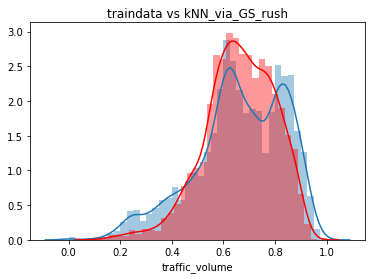

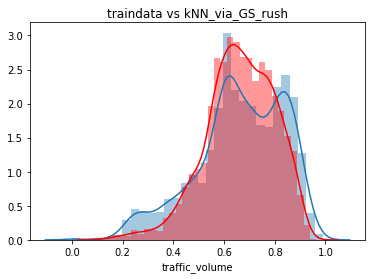

In [25]:
model_cv = neighbors.KNeighborsRegressor(n_neighbors=model.best_params_['n_neighbors'])
model_cv.fit(X_train, Y_train)
pred_cv = model.predict(X_test)
a = print_score(model_cv, X_train, X_test, Y_train, Y_test)


plt.figure()
sns.distplot(Y_train)
sns.distplot(pred_cv, color="red")
ax = plt.gca()
ax.set_title("traindata vs kNN_via_GS_rush")
fig = sns_plot.get_figure()
plt.xlabel("traffic_volume")
fig.savefig("plots/Metro/traindata vs kNN_via_GS_rush")

plt.figure()
sns.distplot(Y_test)
sns.distplot(pred_cv, color="red")
ax = plt.gca()
ax.set_title("traindata vs kNN_via_GS_rush")
fig = sns_plot.get_figure()
plt.xlabel("traffic_volume")
fig.savefig("plots/Metro/testdata vs kNN_via_GS_rush")

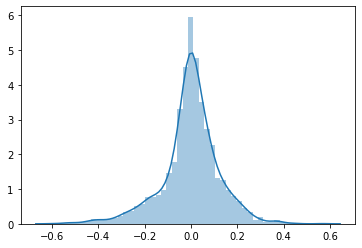

In [26]:
sns.distplot(Y_test-pred_cv)

# d) Random Forest

In [27]:
# Imports for RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from IPython.display import display

In [28]:
df_rf = df_raw
# Split for random forest
rnd_state = 42
ratio = 0.2 # test/num_samples
#####
num_instances, _ = df_rf.shape
print(f"From {num_instances} using {num_instances*ratio:.0f} for testing and {num_instances*(1-ratio):.0f} for training. Ratio = {ratio*100:.2f}%")
X, Y = (df_rf.drop(['traffic_volume'], axis=1), df_rf.traffic_volume)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ratio, random_state = rnd_state)
display(X_test)

From 48204 using 9641 for testing and 38563 for training. Ratio = 20.00%


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,hour,day,month,year
35748,0,0.691362,0.0,0.0,0.01,0.6,0.243243,7,28,7,2017
147,0,0.539292,0.0,0.0,0.01,0.1,0.081081,21,8,10,2012
24362,0,0.719856,0.0,0.0,0.36,0.0,0.000000,0,22,6,2016
35495,0,0.759298,0.0,0.0,0.90,0.7,0.756757,22,19,7,2017
11010,0,0.379424,0.0,0.0,0.64,0.4,0.189189,9,27,12,2013
...,...,...,...,...,...,...,...,...,...,...,...
6401,0,0.659718,0.0,0.0,0.90,0.7,0.432432,22,25,5,2013
34004,0,0.646221,0.0,0.0,0.01,0.1,0.081081,9,25,5,2017
46086,0,0.771296,0.0,0.0,0.20,0.0,0.108108,22,22,7,2018
42579,0,0.486953,0.0,0.0,0.90,0.0,0.054054,22,23,3,2018


In [29]:
before = 0

In [30]:
# Simple training of RFRegressor
n_cores = 4
rf_W = RandomForestRegressor(n_jobs=n_cores)
# The following code is supposed to fail due to string values in the input data
rf_W.fit(X_train, Y_train)
print("Before:")
display(before)#
print("Now:")
before = print_score(rf_W, X_train, X_test, Y_train, Y_test)

Before:


0

Now:


{'RMS(train)': 0.04061418545125073,
 'RMS(test)': 0.10881800345563056,
 'R2(train)': 0.9778454106229704,
 'R2(test)': 0.8412619529740805}

In [31]:
print_RF_featureImportance(rf_W, X_train)

holiday: 0.00001		... Name of the holiday (object)
temp: 0.07628		... temperature[Kelvin]
rain_1h: 0.00630		... Amount of rain in 1 hour[mm]
snow_1h: 0.00004		... Amount of snow in 1 hour[mm]
clouds_all: 0.01564		... percentage of clounds 
weather_main: 0.00853		... discribe the current wheather situation
weather_description: 0.01426		... more precise description of the weather situation
hour: 0.78105		... hour
day: 0.05142		... day
month: 0.02440		... month
year: 0.02208		... year
+---------------------+--------+---------------------------------------------------+
|       Feature       | Score  |                      Comment                      |
+---------------------+--------+---------------------------------------------------+
|       holiday       |  0.0   |            Name of the holiday (object)           |
|         temp        | 0.0763 |                temperature[Kelvin]                |
|       rain_1h       | 0.0063 |            Amount of rain in 1 hour[mm]           |
|  

In [32]:
rf_W_prediction = rf_W.predict(X_test)

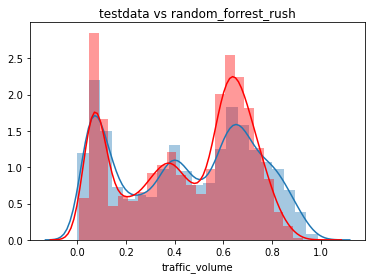

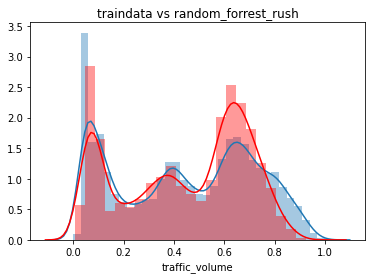

In [33]:
plt.figure()
sns_plot = sns.distplot(Y_test)
sns.distplot(rf_W_prediction, color="red")
ax = plt.gca()
ax.set_title("testdata vs random_forrest_rush")
fig = sns_plot.get_figure()
plt.xlabel("traffic_volume")
fig.savefig("plots/Metro/testdata vs random_forrest_rush")

plt.figure()
sns_plot = sns.distplot(Y_train)
sns.distplot(rf_W_prediction, color="red")
ax = plt.gca()
ax.set_title("traindata vs random_forrest_rush")
fig = sns_plot.get_figure()
plt.xlabel("traffic_volume")
fig.savefig("plots/Metro/traindata vs random_forrest_rush")

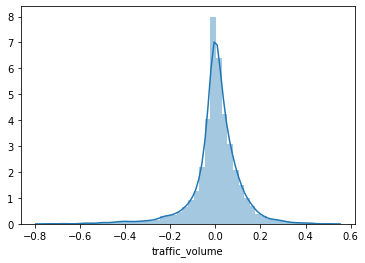

In [34]:
sns.distplot(Y_test-rf_W_prediction)

In [35]:
n_cores = 4
number_of_trees = 100 # default = 100
rf = RandomForestRegressor(n_jobs=n_cores, n_estimators=number_of_trees, bootstrap=True) #, verbose=1)

rf.fit(X_train, Y_train)
print("Before:")
display(before)#
print("Now:")
before = print_score(rf, X_train, X_test, Y_train, Y_test)
print()
print("Feature importance")
print_RF_featureImportance(rf, X_train)
rf_RD = rf

Before:


{'RMS(train)': 0.04061418545125073,
 'RMS(test)': 0.10881800345563056,
 'R2(train)': 0.9778454106229704,
 'R2(test)': 0.8412619529740805}

Now:


{'RMS(train)': 0.040984074262690434,
 'RMS(test)': 0.1089427905789732,
 'R2(train)': 0.9774400325058494,
 'R2(test)': 0.8408976782895746}


Feature importance
holiday: 0.00001		... Name of the holiday (object)
temp: 0.07635		... temperature[Kelvin]
rain_1h: 0.00627		... Amount of rain in 1 hour[mm]
snow_1h: 0.00003		... Amount of snow in 1 hour[mm]
clouds_all: 0.01567		... percentage of clounds 
weather_main: 0.00853		... discribe the current wheather situation
weather_description: 0.01425		... more precise description of the weather situation
hour: 0.78130		... hour
day: 0.05135		... day
month: 0.02444		... month
year: 0.02180		... year
+---------------------+--------+---------------------------------------------------+
|       Feature       | Score  |                      Comment                      |
+---------------------+--------+---------------------------------------------------+
|       holiday       |  0.0   |            Name of the holiday (object)           |
|         temp        | 0.0764 |                temperature[Kelvin]                |
|       rain_1h       | 0.0063 |            Amount of rain in 1 hour

In [36]:
rfRD_prediction = rf_RD.predict(X_test)

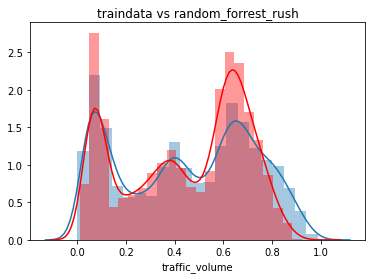

In [37]:
plt.figure()
sns.distplot(Y_test)
sns.distplot(rfRD_prediction, color="red")
ax = plt.gca()
ax.set_title("traindata vs random_forrest_rush")
fig = sns_plot.get_figure()
plt.xlabel("traffic_volume")
fig.savefig("plots/Metro/traindata vs random_forrest_rush")

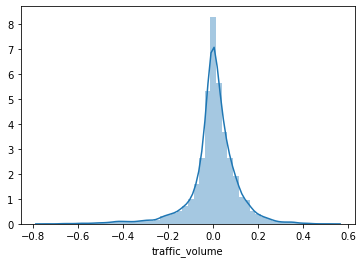

In [38]:
sns.distplot(Y_test-rfRD_prediction)

# Optimize Hyperparameters via GridSearch

because we lazy bois

## Notes on the RandomForestRegressor from scikit-learn
-----
The default values for the parameters controlling the size of the trees
(e.g. ``max_depth``, ``min_samples_leaf``, etc.) lead to fully grown and
unpruned trees which can potentially be very large on some data sets. To
reduce memory consumption, the complexity and size of the trees should be
controlled by setting those parameter values.

## Number of variables/features per tree --> 'max_features'

A good starting point is/might be: *the square root of the number of features presented to the tree*. Then, test some values below and above that starting point.

## Number of trees in the forest --> 'n_estimators'

The more the merrier

In [39]:
from numpy import sqrt
num_features = X.shape[1]
print(num_features)
sqrt_num_features = round(sqrt(num_features), 0)
sqrt_num_features

11


3.0

In [40]:
from sklearn.model_selection import GridSearchCV
n_cores = 4
# but since we dont have that many features...we are just gonna brute force it :D
param_grid = [
    {
        'n_estimators': [3, 10, 30, 40, 100], 'max_features': [i for i in range(1,num_features+1)]
    }
#,{'bootstrap': [False], 'n_estimators': [3, 30, 100, 1000], 'max_features': [2, 3, 4]},
]
k = 2
forest_reg = RandomForestRegressor(n_jobs=n_cores)
grid_search = GridSearchCV(forest_reg, param_grid, n_jobs=n_cores , cv=k, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, Y_train)


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=4,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [41]:
print_GridSearchResult(grid_search)
scores = grid_search.score(X_test, Y_test)
print_score(grid_search, X_train, X_test, Y_train, Y_test)

{'max_features': 3, 'n_estimators': 100}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


{'RMS(train)': 0.0384506644774186,
 'RMS(test)': 0.1028868475353583,
 'R2(train)': -0.001478453598755021,
 'R2(test)': -0.010585703395764064}

{'RMS(train)': 0.0384506644774186,
 'RMS(test)': 0.1028868475353583,
 'R2(train)': -0.001478453598755021,
 'R2(test)': -0.010585703395764064}

In [42]:
print('R2(Test):', metrics.mean_squared_error(Y_test, grid_search.predict(X_test)))  
print('RMS(Test):', np.sqrt(metrics.mean_squared_error(Y_test, grid_search.predict(X_test))))

R2(Test): 0.010585703395764064
RMS(Test): 0.1028868475353583
